## Problem
 -  https://zindi.africa/competitions/flight-delay-prediction-challenge


- Column data :
    - DATOP - Date of flight
    - FLTID - Flight number
    - DEPSTN - Departure point
    - ARRSTN - Arrival point
    - STD - Scheduled Time departure
    - STA - Scheduled Time arrival
    - STATUS - Flight status
    - ETD - Expected Time departure
    - ETA - Expected Time arrival
    - ATD - Actual Time of Departure
    - AC  - AirCraft code
  

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import yaml
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
# import eli5
# from eli5.sklearn import PermutationImportance
import category_encoders as ce
import seaborn as sns


In [65]:

with open ("E:\Etisalat\Projects\ML\data_paths.yaml",'r') as file:
    data=yaml.safe_load(file)


df=data['train_path']

df=pd.read_csv(df)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/etisalat/Train.csv'

In [ ]:
df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


In [ ]:
df.describe()

,target
count,107833.000000
mean,48.733013
std,117.135562
min,0.000000
25%,0.000000
50%,14.000000
75%,43.000000
max,3451.000000


- From describe function :
   -  The maximum delay 2 and half day from its scheduled time
   -  Half of all secheduled flights are delayed 14 min

In [ ]:
len(df.duplicated()==False)==len(df)

True

In [ ]:
len(df['FLTID'].unique())

1861

In [ ]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

In [ ]:
df['STATUS'].value_counts()

STATUS
ATA    93679
SCH    13242
DEP      467
RTR      294
DEL      151
Name: count, dtype: int64

In [ ]:
df.nunique()

ID        107833
DATOP       1011
FLTID       1861
DEPSTN       132
ARRSTN       128
STD        81697
STA        85136
STATUS         5
AC            68
target       968
dtype: int64

In [6]:
#first replace the . with :
df['STD']=df['STD'].apply(lambda x : x.replace('.',':'))
df['STA']=df['STA'].apply(lambda x : x.replace('.',':'))
# Then convert the object to date type
dates_flight=['DATOP','STD','STA']
for i in dates_flight :
    df[i] =pd.to_datetime(df[i])


#create a column with the differnce between the STD AND STA in MINs
df['DIFF_STD_STA']=(df['STA']-df['STD'] ).dt.total_seconds() /60

In [ ]:
value_counts = df['DEPSTN'].value_counts()
print(value_counts)

DEPSTN
TUN    42522
DJE    10252
ORY     6755
MIR     5248
MRS     2845
       ...  
GHA        1
KRR        1
STR        1
TPS        1
CTA        1
Name: count, Length: 132, dtype: int64


In [ ]:
len(df['DEPSTN'].unique())

132

In [ ]:
flight_points_0= df[df['target'] == 0]
flight_points_1= df[df['target'] == 1]
#Group by DEPSTN and ARRSTN
flight_points_0 = flight_points_0[['DEPSTN', 'ARRSTN']].groupby(['DEPSTN', 'ARRSTN']).size().reset_index(name='NO_DELAYS')
flight_points_1=flight_points_0[['DEPSTN', 'ARRSTN']].groupby(['DEPSTN', 'ARRSTN']).size().reset_index(name='DALAYS')

In [ ]:
merged = pd.merge(flight_points_0, flight_points_1, on=['DEPSTN', 'ARRSTN'], how='outer')
sorted_merged = merged.sort_values(by='NO_DELAYS', ascending=False)
sorted_merged

,DEPSTN,ARRSTN,NO_DELAYS,DALAYS
555,TUN,TUN,4150,1
138,DJE,TUN,3248,1
499,TUN,DJE,2902,1
392,ORY,TUN,808,1
540,TUN,ORY,627,1
...,...,...,...,...
553,TUN,TPS,1,1
554,TUN,TRN,1,1
562,VCE,VCE,1,1
2,ABJ,BKO,1,1


In [ ]:
len(df['AC'].unique())

68

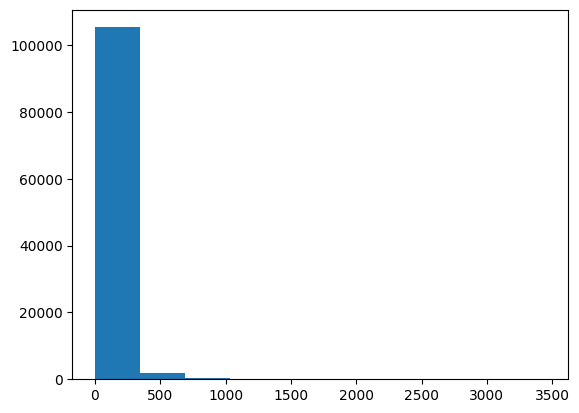

In [ ]:
plt.hist(x=df['target'])
plt.show()

<Axes: xlabel='STATUS', ylabel='target'>

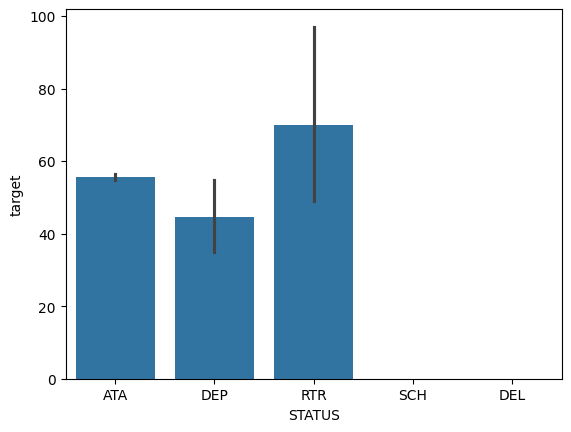

In [ ]:
sns.barplot(df,x='STATUS',y='target')

In [ ]:
df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'DIFF_STD_STA'],
      dtype='object')

In [7]:
df_Cp=df.copy()
columns_drop=['ID','DATOP','FLTID','STD', 'STA','AC']
df_Cp.drop(columns=columns_drop,inplace=True)

In [ ]:
df_Cp.head()

,DEPSTN,ARRSTN,STATUS,target,DIFF_STD_STA
0,CMN,TUN,ATA,260.0,145.0
1,MXP,TUN,ATA,20.0,110.0
2,TUN,IST,ATA,0.0,155.0
3,DJE,NTE,ATA,0.0,170.0
4,TUN,ALG,ATA,22.0,80.0


##  Preprocessing

In [8]:
categorical_features=[ col_name for col_name in df_Cp.columns if df[col_name].dtype=='object']
neumeric_features=[ col_name for col_name in df_Cp.columns if df[col_name].dtype!='object' and col_name!='target']
print(categorical_features,'\n',
      neumeric_features)

['DEPSTN', 'ARRSTN', 'STATUS'] 
 ['DIFF_STD_STA']


In [9]:
X=df_Cp.drop(columns=['target'])
y=df_Cp['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Apply some techniques for showing the impact of the features on the model after traning
- Permutation Improvment
- Partial Dependency
- SHAP Analysis

In [27]:
def train_model(model, X_train, y_train, X_test, y_test):

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), neumeric_features),
            ('cat', ce.TargetEncoder(cols=categorical_features), categorical_features)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)

    score = pipeline.score(X_test, y_test)
    print("Final model score:", score)
    return pipeline, predictions

lr = LinearRegression()
pipeline_res, predictions = train_model(lr, X_train, y_train, X_test, y_test)

X_test_transformed = pipeline_res.named_steps['preprocessor'].transform(X_test)

perm_importance = PermutationImportance(pipeline_res.named_steps['model'], random_state=42)
perm_importance.fit(X_test_transformed, predictions)

eli5.show_weights(perm_importance, feature_names=pipeline_res.named_steps['preprocessor'].get_feature_names_out())




Final model score: 0.03655775167633102


Weight,Feature
0.6145 ± 0.0097,cat__STATUS
0.6023 ± 0.0100,cat__DEPSTN
0.3039 ± 0.0026,cat__ARRSTN
0.0000 ± 0.0000,num__DIFF_STD_STA


-  Partial Dependency

In [31]:
import shap

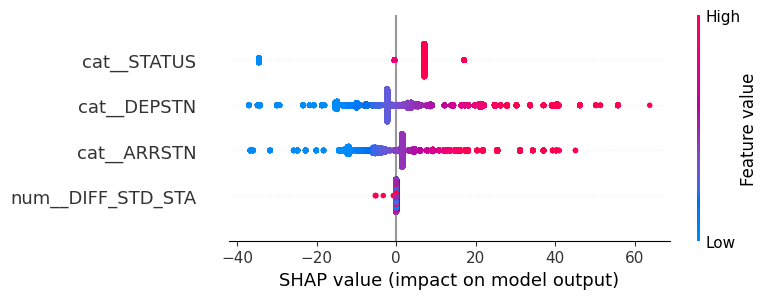

In [32]:
explainer = shap.Explainer(pipeline_res.named_steps['model'], X_test_transformed)
shap_values = explainer(X_test_transformed)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=pipeline_res.named_steps['preprocessor'].get_feature_names_out())
